In [2]:
import os
import sys
import glob
import itertools

from IPython.display import Image

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.colors import ListedColormap
from scipy.stats import multivariate_normal

import numpy as np
import pandas as pd
from scipy.stats import beta



%matplotlib inline

## Mondrian Processes

### Various Functions for Mondrian Processes

Sampling...

In [3]:
### SAMPLE MONDRIAN PROCESS ###

def draw_Mondrian(theta_space, budget=5):
    return draw_Mondrian_at_t(theta_space, 0, budget)
    
def draw_Mondrian_at_t(theta_space, t, budget):
    dists = theta_space[:,1] - theta_space[:,0]
    lin_dim = np.sum(dists)
    T = np.random.exponential(scale=1./lin_dim)
    
    if t+T > budget: 
        return (theta_space, None, None)
    
    d = np.argmax(np.random.multinomial(n=1, pvals=dists/lin_dim))
    x = np.random.uniform(low=theta_space[d,0], high=theta_space[d,1])
    
    theta_left = np.copy(theta_space)
    theta_left[d][1] = x 
    M_left = draw_Mondrian_at_t(theta_left, t+T, budget)
    
    theta_right = np.copy(theta_space)
    theta_right[d][0] = x 
    M_right = draw_Mondrian_at_t(theta_right, t+T, budget)
    
    return (theta_space, M_left, M_right)

def comp_log_p_sample(theta_space, data):
    if theta_space[1] == None and theta_space[2] == None:
        if data.shape[0] == 0:
            return 0
        else:
            mu = np.mean(data, axis = 0)
            residual = data - mu
            cov = np.dot(residual.T , residual) / data.shape[0] + np.identity(data.shape[1])*0.001
            return np.log(multivariate_normal.pdf(data, mean=mu, cov=cov)).sum()
    
    # find the dimension and location of first cut
    root_rec = theta_space[0]
    left_rec = theta_space[1][0]
    
    for _ in range(root_rec.shape[0]):
        if root_rec[_,1] != left_rec[_,1]:
            break
    
    dim, pos = _, left_rec[_,1]
    idx_left = data[:,dim] < pos
    idx_right = data[:,dim] >= pos
    log_len_left =  np.log(pos - root_rec[dim,0])
    log_len_right = np.log(root_rec[dim,1] - pos)
    return comp_log_p_sample(theta_space[1], data[idx_left]) + comp_log_p_sample(theta_space[2], data[idx_right])
     

# def comp_log_p_sample(theta_space, data):
#     if theta_space[1] == None and theta_space[2] == None:
#         return 0
    
#     # find the dimension and location of first cut
#     root_rec = theta_space[0]
#     left_rec = theta_space[1][0]
    
#     for _ in range(root_rec.shape[0]):
#         if root_rec[_,1] != left_rec[_,1]:
#             break
    
#     dim, pos = _, left_rec[_,1]
#     idx_left = data[:,dim] < pos
#     idx_right = data[:,dim] >= pos
#     log_len_left =  np.log(pos - root_rec[dim,0])
#     log_len_right = np.log(root_rec[dim,1] - pos)
#     return - idx_left.sum() * log_len_left - idx_right.sum() * log_len_right +\
#             comp_log_p_sample(theta_space[1], data[idx_left]) + comp_log_p_sample(theta_space[2], data[idx_right])
    

Visualization...

In [4]:
### VISUALIZE 2D MONDRIAN PROCESS ###
def print_partitions(p, trans_level=1., color='k'):
    if not p[1] and not p[2]: 
        plt.plot([p[0][0,0], p[0][0,0]], [p[0][1,0], p[0][1,1]], color+'-', linewidth=5, alpha=trans_level)
        plt.plot([p[0][0,1], p[0][0,1]], [p[0][1,0], p[0][1,1]], color+'-', linewidth=5, alpha=trans_level)
        plt.plot([p[0][0,0], p[0][0,1]], [p[0][1,0], p[0][1,0]], color+'-', linewidth=5, alpha=trans_level)
        plt.plot([p[0][0,0], p[0][0,1]], [p[0][1,1], p[0][1,1]], color+'-', linewidth=5, alpha=trans_level)
    
    else:
        print_partitions(p[1], trans_level, color)
        print_partitions(p[2], trans_level, color)
        
        
### VISUALIZE 2D POSTERIOR WITH DATA###
def print_posterior(data, samples, trans_level=.05, color='k'):

    plt.figure()
    plt.scatter(data[:,0], data[:,1], c='k', edgecolors='k', s=5, alpha=.5)

    #print all samples
    for sample in samples:
        print_partitions(sample, trans_level, color)
        
        
def print_tree_at_leaf(mp_tree, table):

    if mp_tree[1] == None and mp_tree[2] == None: 
        print table.shape
        return 1
    
    
    # find the dimension and location of first cut
    root_rec = mp_tree[0]
    left_rec = mp_tree[1][0]
    
    for _ in range(root_rec.shape[0]):
        if root_rec[_,1] != left_rec[_,1]:
            break
    d, pos = _, left_rec[_,1]
    
    cut_type = ' '.join([str(int(x)) for x in sorted(set(table[table.columns[d]]))]) 
    
    if cut_type in {"-1 0 1", '-1 1'}: 
        idx_table_left = table[table.columns[d]] != 1
        table_left = table.loc[idx_table_left]

        idx_table_right = table[table.columns[d]] != -1
        table_right = table.loc[idx_table_right]
    
    if cut_type == '-1 0':
        idx_table_left = table[table.columns[d]] == -1
        table_left = table.loc[idx_table_left]

        idx_table_right = table[table.columns[d]] == 0
        table_right = table.loc[idx_table_right]
        

    if cut_type == '0 1':
        idx_table_left = table[table.columns[d]] == 0
        table_left = table.loc[idx_table_left]

        idx_table_right = table[table.columns[d]] == 1
        table_right = table.loc[idx_table_right]
    
    return print_tree_at_leaf(mp_tree[1], table_left) + print_tree_at_leaf(mp_tree[2], table_right)


## Mondrian Process Generative Model

We apply Mondrian Processes (MPs) to flow cytometry data, using the prior information in the table above to guide the axis-aligned cuts.  Instead of uniformly, we draw the cut proportion from $w \sim \text{Beta}(a_{0}, b_{0})$. 

Now let's re-implement the MP sampling function, accounting for the prior information...

In [5]:
### SAMPLE MONDRIAN PROCESS WITH PRIOR INFORMATION ###
def draw_informed_Mondrian(theta_space, table, budget=5):
    
    # INFORMATIVE PRIORS
    upper_cut = (5., 2.)
    lower_cut = (2., 5.)
    middle_cut = (5., 5.)
    neutral_cut = (2., 2.)
    priors_dict = { '-1':lower_cut, '0':neutral_cut, '1':upper_cut, 
                   '-1 0':lower_cut, '-1 1':middle_cut, '0 1':upper_cut,
                   '-1 0 1': middle_cut, '': neutral_cut
                  }
    
    cut_history = [1] * theta_space.shape[0]
    
    return draw_informed_Mondrian_at_t(theta_space, table, priors_dict, cut_history)
    

def draw_informed_Mondrian_at_t(theta_space, table, priors_dict, cut_history):    
    
    if sum(cut_history) == 0 or table.shape[0] == 1:
        return (theta_space, None, None)

    
    types_str = [' '.join([str(int(x)) for x in sorted(set(table[table.columns[d]]))]) 
                 for d in range(table.shape[1])]
    
    if set([types_str[d] for d in range(table.shape[1]) if cut_history[d] == 1]).issubset({'0','1','-1'}):
        return (theta_space, None, None)

    
    low, medium, high, very_high = 0, 1, 100, 1000
    priority_dict = {'-1': low , '0': low, '1': low, 
                   '-1 0': medium, '0 1': medium,
                   '-1 0 1': high, '-1 1':very_high
    }    
        
    types = np.array([priority_dict[_] for _ in types_str])
    

    dists = (theta_space[:,1] - theta_space[:,0])* types    
    lin_dim = np.sum(dists)
    # draw dimension to cut
    dim_probs = ((dists/lin_dim) * np.array(cut_history)) 
    dim_probs /= np.sum(dim_probs)
    d = np.argmax(np.random.multinomial(n=1, pvals=dim_probs))
    cut_history[d] = 0

    prior_type_str = ' '.join([str(int(x)) for x in sorted(set(table[table.columns[d]]))])
    prior_params = priors_dict[prior_type_str]
    
    # make scaled cut
    x = (theta_space[d,1] - theta_space[d,0]) * np.random.beta(prior_params[0], prior_params[1]) + theta_space[d,0]
    
    cut_type = types_str[d]
    
    if cut_type in {"-1 0 1", '-1 1'}: 
        idx_table_left = table[table.columns[d]] != 1
        table_left = table.loc[idx_table_left]

        idx_table_right = table[table.columns[d]] != -1
        table_right = table.loc[idx_table_right]
    
    if cut_type == '-1 0':
        idx_table_left = table[table.columns[d]] == -1
        table_left = table.loc[idx_table_left]

        idx_table_right = table[table.columns[d]] == 0
        table_right = table.loc[idx_table_right]
        

    if cut_type == '0 1':
        idx_table_left = table[table.columns[d]] == 0
        table_left = table.loc[idx_table_left]

        idx_table_right = table[table.columns[d]] == 1
        table_right = table.loc[idx_table_right]

    
    # make lower partition
    theta_left = np.copy(theta_space)
    theta_left[d][1] = x
    M_left = draw_informed_Mondrian_at_t(theta_left, table_left, priors_dict, list(cut_history))
    
    # make upper partition
    theta_right = np.copy(theta_space)
    theta_right[d][0] = x 
    M_right = draw_informed_Mondrian_at_t(theta_right, table_right, priors_dict,list(cut_history))
    
    return (theta_space, M_left, M_right)

def Mondrian_Gaussian_perturbation(theta_space, old_sample, stepsize):
    """
    Input: 
    theta_space: a rectangle
    old_sample: partioned theta_space of a mondrian process
    stepsize: gaussian std
    """
    if old_sample[1] == None and old_sample[2] == None:
        return (theta_space, None, None)
    
    # find the dimension and location of first cut in the old_sample
    for _ in range(old_sample[0].shape[0]):
        if old_sample[0][_,1] > old_sample[1][0][_,1]:
            break    
    dim, pos = _, old_sample[1][0][_,1]
    # propose position of new cut
    good_propose = False
    while good_propose == False:
        new_pos = pos + np.random.normal(0,(old_sample[0][dim,1] - old_sample[0][dim,0])*stepsize,1)[0]
        if new_pos < theta_space[dim,1] and new_pos > theta_space[dim,0]:
            good_propose = True
    
    theta_left = np.copy(theta_space)
    theta_left[dim,1] = new_pos
    theta_right = np.copy(theta_space)
    theta_right[dim,0] = new_pos
    
    new_M_left= Mondrian_Gaussian_perturbation(theta_left, old_sample[1], stepsize)
    new_M_right = Mondrian_Gaussian_perturbation(theta_right, old_sample[2], stepsize)
    
    return (theta_space, new_M_left, new_M_right)

def comp_log_p_prior(theta_space, table, cut_history):
    """
    This function returns prior probability of a Mondrian process theta_space
    """
    if theta_space[1] == None and theta_space[2] == None:
        return 0
    
    log_prior = 0
    

    # INFORMATIVE PRIORS
    upper_cut = (5., 2.)
    lower_cut = (2., 5.)
    middle_cut = (5., 5.)
    neutral_cut = (2., 2.)
    priors_dict = { '-1':lower_cut, '0':neutral_cut, '1':upper_cut, 
                   '-1 0':lower_cut, '-1 1':middle_cut, '0 1':upper_cut,
                   '-1 0 1': middle_cut, '': neutral_cut
                  }
    
    
    # find the dimension and location of first cut
    root_rec = theta_space[0]
    left_rec = theta_space[1][0]
    
    for _ in range(root_rec.shape[0]):
        if root_rec[_,1] != left_rec[_,1]:
            break
    dim  = _
    beta_pos =  (left_rec[_,1] - left_rec[dim,0])/(root_rec[dim,1] - root_rec[dim, 0])
    
    prior_params = priors_dict[' '.join([str(int(x)) \
                                         for x in sorted(set(table[table.columns[dim]]))])]

    # compute the log likelihood of the first cut
    types_str = [' '.join([str(int(x)) for x in sorted(set(table[table.columns[d]]))]) 
                 for d in range(table.shape[1])]
    
    low_priority, medium_priority, high_priority, very_high_priority = 0, 1, 100, 1000
    priority_dict = {'-1': low_priority , '0': low_priority, '1': low_priority, 
                   '-1 0': medium_priority, '0 1': medium_priority,
                   '-1 0 1': high_priority, '-1 1':very_high_priority
    }    
        
    types = np.array([priority_dict[_] for _ in types_str])
    dists = (root_rec[:,1] - root_rec[:,0])* types    
    lin_dim = np.sum(dists)
    
    # probability of dim
    dim_probs = ((dists/lin_dim) * np.array(cut_history)) 
    dim_probs /= np.sum(dim_probs)
    log_prior  += np.log(dim_probs[dim])
    
    
    # probability of pos
    log_prior += np.log(beta.pdf(beta_pos, prior_params[0], prior_params[1]))
    
    # split the table
    cut_history[dim] = 0
    cut_type = types_str[dim]
    
    if cut_type in {"-1 0 1", '-1 1'}: 
        idx_table_left = table[table.columns[dim]] != 1
        table_left = table.loc[idx_table_left]

        idx_table_right = table[table.columns[dim]] != -1
        table_right = table.loc[idx_table_right]
    
    if cut_type == '-1 0':
        idx_table_left = table[table.columns[dim]] == -1
        table_left = table.loc[idx_table_left]

        idx_table_right = table[table.columns[dim]] == 0
        table_right = table.loc[idx_table_right]
        

    if cut_type == '0 1':
        idx_table_left = table[table.columns[dim]] == 0
        table_left = table.loc[idx_table_left]

        idx_table_right = table[table.columns[dim]] == 1
        table_right = table.loc[idx_table_right]
        
        
        
    return log_prior + comp_log_p_prior(theta_space[1], table_left, list(cut_history)) \
        + comp_log_p_prior(theta_space[2], table_right, list(cut_history))

# Classification

In [6]:
def classify_cells(data, mp_tree, table, cell_type_name2idx):
    Y = np.array([1]*data.shape[0])
    
    if data.shape[0] == 0:
        return Y
    
    if mp_tree[1] == None and mp_tree[2] == None:
        if table.shape[0] > 1:
#            print "more than one clusters, number of data points:", data.shape[0]
            labels = [cell_type_name2idx[table.index[_]] for _ in range(table.shape[0])]
            return np.array(np.random.choice(labels, data.shape[0],replace = True))
        else:
            return Y * cell_type_name2idx[table.index[0]]
    
    
    # find the dimension and location of first cut
    root_rec = mp_tree[0]
    left_rec = mp_tree[1][0]
    
    for _ in range(root_rec.shape[0]):
        if root_rec[_,1] != left_rec[_,1]:
            break
    dim, pos = _, left_rec[_,1]
    
    # find labels that match dim info from table
    idx_table_left = table[table.columns[dim]] != 1
    table_left = table.loc[idx_table_left]

    idx_table_right = table[table.columns[dim]] != -1
    table_right = table.loc[idx_table_right]
    
    # find data INDICIES that go high / low on cut position in dimension dim
    idx_left = data[:,dim]  < pos
    idx_right = data[:,dim]  >= pos
    
    Y[idx_left] = classify_cells(data[idx_left],mp_tree[1],table_left, cell_type_name2idx)
    Y[idx_right] = classify_cells(data[idx_right],mp_tree[2],table_right, cell_type_name2idx)

    return Y

## Flow Cytometry Data

Load BMMC dataset from [ACDC paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5447237/pdf/btx054.pdf)...

In [7]:
# load BMMC data and table
##### X: np.array, flow cytometry data, arcsin transformed
##### T: table of expert knowledge

np.random.seed(1234)
PATH = '/home/disij/projects/acdc/data/'

### LOAD DATA ###
path = PATH + 'BMMC_benchmark/'
df = pd.read_csv( path + 'BMMC_benchmark.csv.gz', sep=',', header = 0, compression = 'gzip', engine='python')
table = pd.read_csv(path + 'BMMC_table.csv', sep=',', header=0, index_col=0)
print table.shape

### PROCESS: discard ungated events ###
channels = ['CD45','CD45RA', 'CD19', 'CD11b', 'CD4', 'CD8', 'CD34',
           'CD20', 'CD33', 'CD123', 'CD38', 'CD90', 'CD3']
df.columns = channels + ['cell_type']
df = df[df.cell_type != 'NotGated']
df = df.loc[df['cell_type'] != 'NotDebrisSinglets']

table = table.fillna(0)
X = df[channels].values
print df.shape

### transform data
data = np.arcsinh((X-1.)/5.)
theta_space = np.array([[data[:,d].min(), data[:,d].max()] for d in range(data.shape[1])])


cell_type_name2idx = {x:i for i,x in enumerate(table.index)}
cell_type_name2idx['unknown'] = len(cell_type_name2idx)
Y = np.array([cell_type_name2idx[_]  
              if _ in cell_type_name2idx else cell_type_name2idx['unknown']
             for _ in df.cell_type])

(19, 13)
(81747, 14)


In [8]:
print table
print cell_type_name2idx

                  CD45  CD45RA  CD19  CD11b  CD4  CD8  CD34  CD20  CD33  \
Mature CD4+ T      1.0    -1.0    -1    0.0    1   -1   0.0   0.0    -1   
Mature CD8+ T      1.0    -1.0    -1    0.0   -1    1   0.0   0.0    -1   
Naive CD4+ T       1.0     1.0    -1    0.0    1   -1   0.0   0.0    -1   
Naive CD8+ T       1.0     1.0    -1    0.0   -1    1   0.0   0.0    -1   
CD11bhi Monocyte   1.0     0.0    -1    1.0   -1   -1  -1.0   0.0     1   
CD11b- Monocyte    1.0     0.0    -1   -1.0   -1   -1  -1.0   0.0     1   
Pre-B I            0.0     0.0     1    0.0   -1   -1   1.0  -1.0    -1   
Pre-B II           0.0     0.0     1    0.0   -1   -1  -1.0  -1.0    -1   
Immature B         0.0     0.0     1    0.0   -1   -1  -1.0  -1.0    -1   
Mature CD38lo B    0.0     0.0     1    0.0   -1   -1  -1.0   1.0    -1   
Mature CD38mid B   0.0     0.0     1    0.0   -1   -1  -1.0   1.0    -1   
NK                 1.0     1.0    -1    0.0   -1   -1   0.0   0.0    -1   
Plasmacytoid DC    1.0   

In [9]:
# load AML data and table
##### X: np.array, flow cytometry data, arcsin transformed
##### T: table of expert knowledge

np.random.seed(1234)
PATH = '/home/disij/projects/acdc/data/'

### LOAD DATA ###
path = PATH + 'AML_benchmark/'
df = pd.read_csv( path + 'AML_benchmark.csv.gz', sep=',', header = 0, compression = 'gzip', engine='python')
table = pd.read_csv(path + 'AML_table.csv', sep=',', header=0, index_col=0)
print table.shape

### PROCESS: discard ungated events ###
df = df[df.cell_type != 'NotGated']
df = df.drop(['Time', 'Cell_length','file_number', 'event_number', 'DNA1(Ir191)Di',
              'DNA2(Ir193)Di', 'Viability(Pt195)Di', 'subject'], axis = 1)
channels = [item[:item.find('(')] for item in df.columns[:-1]]
df.columns = channels + ['cell_type']
df = df.loc[df['cell_type'] != 'NotDebrisSinglets']
print df.shape

table = table.fillna(0)
X = df[channels].values
table_headers = list(table)
# df2 = pd.DataFrame([[0]*table.shape[1]], columns=table.columns, index =['unknown'])
# table = table.append(df2)

### transform data
data = np.arcsinh((X-1.)/5.)
theta_space = np.array([[data[:,d].min(), data[:,d].max()] for d in range(data.shape[1])])


cell_type_name2idx = {x:i for i,x in enumerate(table.index)}
Y = np.array([cell_type_name2idx[_] for _ in df.cell_type])

df['cell_type'].value_counts()

(14, 32)
(104184, 33)


CD4 T cells               26366
Monocytes                 21099
CD8 T cells               20108
Mature B cells            16520
Pre B cells                6135
CD16- NK cells             3905
CD34+CD38+CD123- HSPCs     3295
CD16+ NK cells             2248
pDCs                       1238
Basophils                  1207
CD34+CD38lo HSCs            916
Pro B cells                 513
Plasma B cells              330
CD34+CD38+CD123+ HSPCs      304
Name: cell_type, dtype: int64

## Experiment #1: 2D Simulation

Let's now test out the idea on a 2D subset of the data: the *CD4* and *CD8* features.

In [ ]:
data_2d = np.hstack([data[:,5][np.newaxis].T, data[:,6][np.newaxis].T])
np.random.shuffle(data_2d)
data_2d = data_2d[:1000,:]
print data_2d.shape

x_min, y_min, x_max, y_max = data_2d[:,0].min(), data_2d[:,1].min(), data_2d[:,0].max(), data_2d[:,1].max()
theta_space_2d = np.array([[x_min, x_max], [y_min, y_max]])
print theta_space_2d

table_2d = table[['CD4','CD8']]

Now run MCMC to collect posterior samples...

In [165]:
%%time

n_mcmc_chain = 5
n_mcmc_sample = 10000
mcmc_gaussin_std = 0.1 # tune step size s.t. acceptance rate ~50%

accepts = [[] for _ in range(n_mcmc_chain)]
rejects = [[] for _ in range(n_mcmc_chain)]
trace_likelihood = [[] for _ in range(n_mcmc_chain)]


for chain in range(n_mcmc_chain):
    
    if chain % 5 == 0:
        print "Drawing Chain %d ..." % chain
    
    sample = draw_informed_Mondrian(theta_space_2d, table_2d)
    log_p_sample = comp_log_p_sample(sample, data_2d)
    trace_likelihood[chain].append(log_p_sample)
    accepts[chain].append(sample)
    
    for idx in xrange(n_mcmc_sample):
        
        new_sample = Mondrian_Gaussian_perturbation(theta_space_2d,sample, mcmc_gaussin_std)

        # perform accept-reject step
        new_log_p_sample = comp_log_p_sample(new_sample, data_2d)        
        if new_log_p_sample <  log_p_sample and \
            np.log(np.random.uniform(low=0, high=1.)) > new_log_p_sample - log_p_sample:
                rejects[chain].append(new_sample)
        
        else:
            sample = new_sample
            log_p_sample = new_log_p_sample
            accepts[chain].append(sample)
            trace_likelihood[chain].append(log_p_sample)

        if (idx+1) % 5000 == 0 and (chain+1) % 1 == 0:
            print "Iteration %d, cummulative accepted sample size is %d" %(idx+1, len(accepts[chain]))

print "Total number of accepted samples: %d" %(sum([len(accepts[chain]) for chain in range(n_mcmc_chain)]))

Drawing Chain 0 ...
Iteration 5000, cummulative accepted sample size is 42
Iteration 10000, cummulative accepted sample size is 80
Iteration 5000, cummulative accepted sample size is 87
Iteration 10000, cummulative accepted sample size is 165
Iteration 5000, cummulative accepted sample size is 76
Iteration 10000, cummulative accepted sample size is 149
Iteration 5000, cummulative accepted sample size is 79
Iteration 10000, cummulative accepted sample size is 154
Iteration 5000, cummulative accepted sample size is 105
Iteration 10000, cummulative accepted sample size is 190
Total number of accepted samples: 738
CPU times: user 1min 11s, sys: 102 ms, total: 1min 11s
Wall time: 1min 11s


In [166]:
# get an average model
burnt_accepts = np.array([_ for chain in accepts for _ in chain[len(chain)*10/11:]])

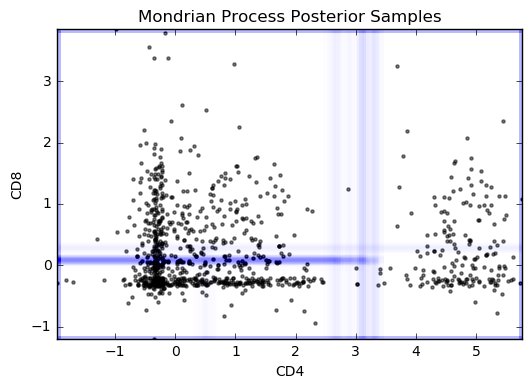

In [167]:
#### plt.figure()

np.random.shuffle(burnt_accepts)
print_posterior(data_2d, burnt_accepts[:100], trans_level=.005, color='b')

plt.xlabel("CD4")
plt.ylabel("CD8")
plt.title("Mondrian Process Posterior Samples")

plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.show()

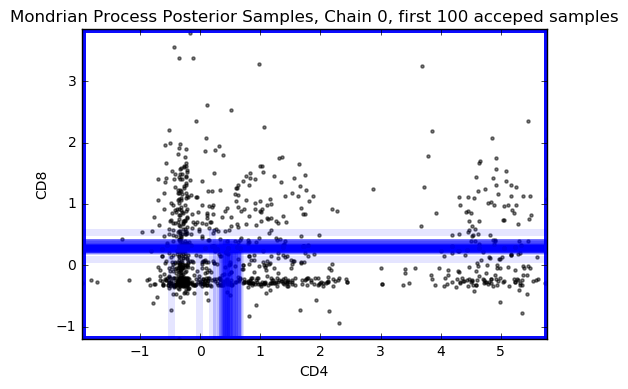

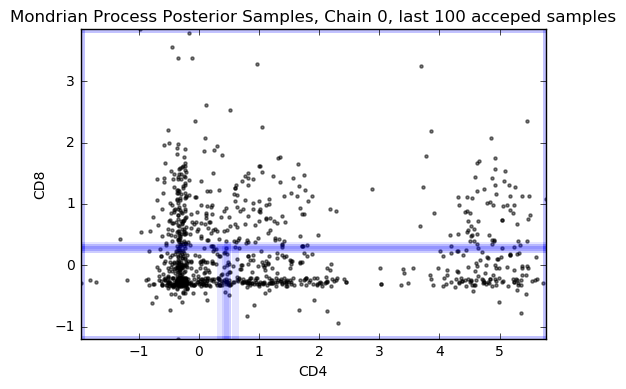

In [168]:
#### plt.figure()


print_posterior(data_2d, accepts[0][:50], trans_level=.05, color='b')

plt.xlabel("CD4")
plt.ylabel("CD8")
plt.title("Mondrian Process Posterior Samples, Chain 0, first 100 acceped samples")

plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.show()



print_posterior(data_2d, accepts[0][-5:], trans_level=.05, color='b')

plt.xlabel("CD4")
plt.ylabel("CD8")
plt.title("Mondrian Process Posterior Samples, Chain 0, last 100 acceped samples")

plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.show()

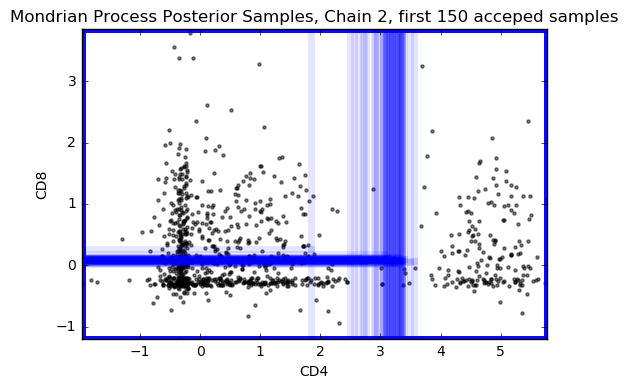

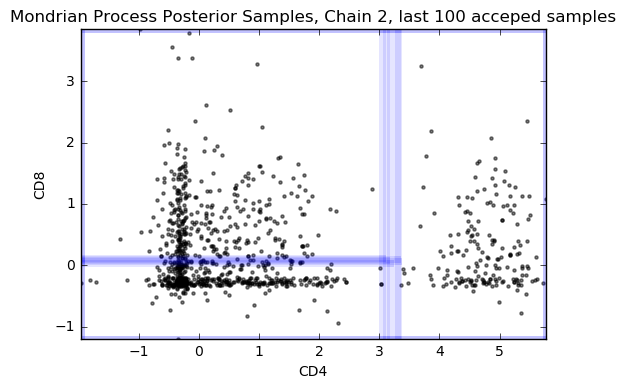

In [169]:
#### plt.figure()

print_posterior(data_2d, accepts[1][:50], trans_level=.05, color='b')

plt.xlabel("CD4")
plt.ylabel("CD8")
plt.title("Mondrian Process Posterior Samples, Chain 2, first 150 acceped samples")

plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.show()


print_posterior(data_2d, accepts[1][-5:], trans_level=.05, color='b')

plt.xlabel("CD4")
plt.ylabel("CD8")
plt.title("Mondrian Process Posterior Samples, Chain 2, last 100 acceped samples")

plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.show()

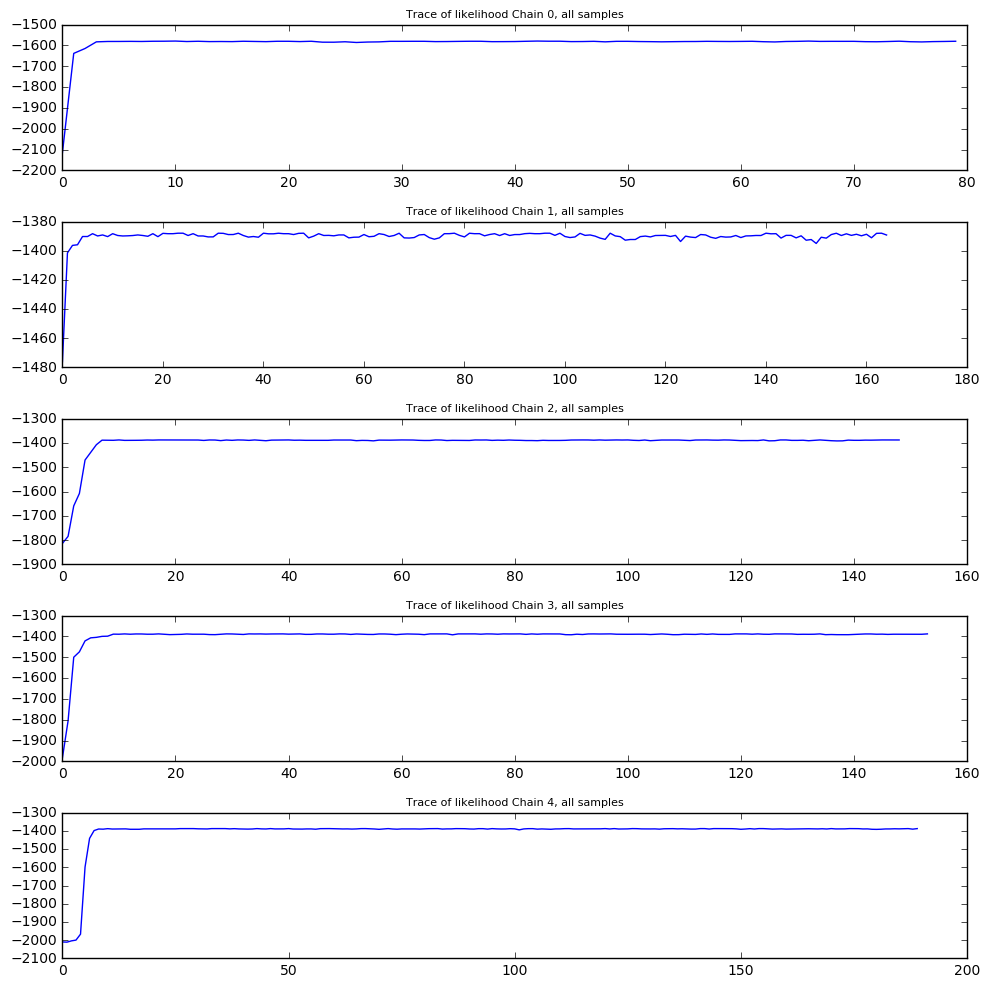

In [170]:
fig, axs = plt.subplots(n_mcmc_chain, figsize=(10,10) )
for chain in range(n_mcmc_chain ):
    axs[chain].plot(trace_likelihood[chain])
    axs[chain].set_title('Trace of likelihood Chain %d, all samples' % chain, fontsize=8)
    
fig.tight_layout()

In [21]:
population = [[0.029, 0.2544, 0.0487, 0.1015, 0.0325, 0.0421, 0.0, 0.03065, 0.20195, 0.0068, 0.01315, 0.0072, 0.1967, 0.03535], [0.11175, 0.27245, 0.05575, 0.05385, 0.0187, 0.03025, 0.0062, 0.01845, 0.2103, 0.0065, 0.00875, 0.0227, 0.17465, 0.0097], [0.0539, 0.2262, 0.05045, 0.05105, 0.01765, 0.04025, 0.05435, 0.07285, 0.2107, 0.00525, 0.01285, 0.0376, 0.10025, 0.06665], [0.0183, 0.27535, 0.05085, 0.0715, 0.02385, 0.0768, 0.051, 0.09155, 0.12815, 0.0017, 0.01245, 0.10635, 0.05335, 0.0388], [0.08745, 0.2418, 0.01065, 0.1312, 0.0437, 0.0132, 0.0187, 0.05555, 0.1645, 0.0, 0.0261, 0.0, 0.07605, 0.1311], [0.12315, 0.3249, 0.0358, 0.05415, 0.01815, 0.00035, 5e-05, 0.00295, 0.2884, 0.0047, 0.03895, 0.0032, 0.0955, 0.00975], [0.02745, 0.3522, 0.026, 0.13455, 0.04575, 0.01455, 0.0004, 0.00685, 0.1702, 0.0017, 0.01305, 0.00245, 0.18765, 0.0172], [0.06355, 0.3313, 0.04645, 0.08905, 0.0394, 0.00795, 0.0084, 0.01385, 0.2651, 0.0023, 0.025, 0.00515, 0.06365, 0.03885], [0.02325, 0.3478, 0.0461, 0.0565, 0.0214, 0.0089, 0.00025, 0.00385, 0.2866, 0.00265, 0.0319, 0.00795, 0.15465, 0.0082], [0.03255, 0.32145, 0.0029, 0.0664, 0.02295, 0.01035, 0.0021, 0.01405, 0.4298, 0.01485, 0.01205, 0.00715, 0.04105, 0.02235]]

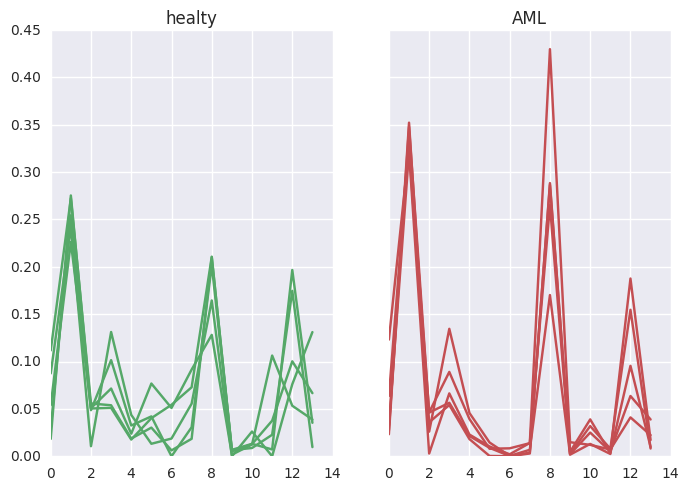

In [106]:
population = np.array(population)
fig, axarr = plt.subplots(1, 2, sharey = True)
for id in range(0,5):
    axarr[0].plot(population[id],color = 'g')
axarr[0].set_title('healty')
for id in range(5,10):
    axarr[1].plot(population[id],color = 'r')
axarr[1].set_title('AML')
plt.show()

In [41]:
a = population[:,5:7]
print a

[[  4.21000000e-02   0.00000000e+00]
 [  3.02500000e-02   6.20000000e-03]
 [  4.02500000e-02   5.43500000e-02]
 [  7.68000000e-02   5.10000000e-02]
 [  1.32000000e-02   1.87000000e-02]
 [  3.50000000e-04   5.00000000e-05]
 [  1.45500000e-02   4.00000000e-04]
 [  7.95000000e-03   8.40000000e-03]
 [  8.90000000e-03   2.50000000e-04]
 [  1.03500000e-02   2.10000000e-03]]


### Explore what happened in the histogram subtree

                        CD123  CD38  CD19
CD34+CD38+CD123+ HSPCs      1   1.0    -1
CD34+CD38+CD123- HSPCs     -1   1.0    -1
CD34+CD38lo HSCs           -1  -1.0    -1
Pro B cells                -1   1.0     1


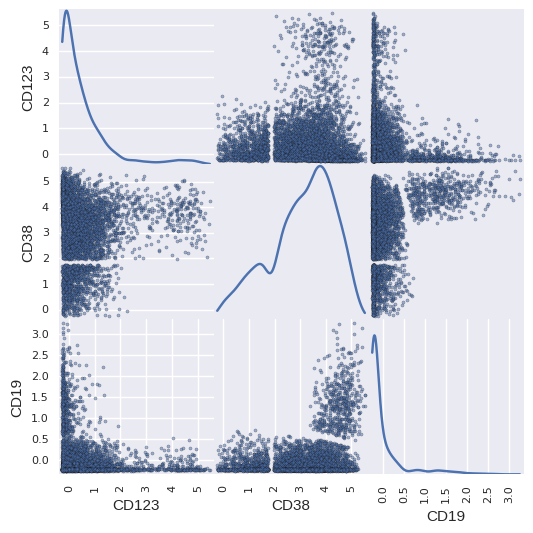

In [104]:
cell_types_subset = ['CD34+CD38+CD123+ HSPCs','CD34+CD38+CD123- HSPCs','CD34+CD38lo HSCs','Pro B cells']
markers_subset = ['CD123','CD38','CD19']
df_subset = df.loc[df['cell_type'].isin(cell_types_subset)]
table_subset = table.loc[cell_types_subset][['CD123','CD38','CD19']]
print table_subset

f = lambda x: np.arcsinh((x -1.)/5.)
df_subset = df_subset[['CD123','CD38','CD19']].applymap(f)
axs = pd.scatter_matrix(df_subset, figsize=(6, 6), diagonal='kde')

In [108]:
%%time

# load data into a dictionary of pandas data frames

np.random.seed(1234)
PATH_DATA = '/extra/disij0/data/flow_cytometry/cytobank/levine_aml/CSV/'
#PATH = '/Users/disiji/Dropbox/current/flow_cytometry/acdc/data/'

user_ids = ['H1','H2','H3','H4','H5','SJ01','SJ02','SJ03','SJ04','SJ05','SJ06','SJ07','SJ08','SJ09','SJ10',\
           'SJ11','SJ12','SJ13','SJ14','SJ15','SJ16']

data_dict = dict()
for id in user_ids:
    print id
    data_path = PATH_DATA + id
    allFiles = glob.glob(data_path + "/*fcsdim_42.csv")
    frame = pd.DataFrame()
    list_ = []
    for file_ in allFiles:
        df = pd.read_csv(file_,index_col=None, header=0)
        list_.append(df)
    data_dict[id] = pd.concat(list_)

markers = ['HLA-DR','CD19','CD34','CD45','CD47','CD44','CD117','CD123','CD38','CD11b',\
                'CD7','CD15','CD3','CD64','CD33','CD41']
 
print markers
    
PATH_TABLE = '/home/disij/projects/acdc/data/AML_benchmark/'
table = pd.read_csv(PATH_TABLE + 'AML_table.csv', sep=',', header=0, index_col=0)
table = table.fillna(0)
table = table[markers]
print table.shape
print table

cell_type_name2idx = {x:i for i,x in enumerate(table.index)}
cell_type_idx2name = {i:x for i,x in enumerate(table.index)}

H1
H2
H3
H4
H5
SJ01
SJ02
SJ03
SJ04
SJ05
SJ06
SJ07
SJ08
SJ09
SJ10
SJ11
SJ12
SJ13
SJ14
SJ15
SJ16
['HLA-DR', 'CD19', 'CD34', 'CD45', 'CD47', 'CD44', 'CD117', 'CD123', 'CD38', 'CD11b', 'CD7', 'CD15', 'CD3', 'CD64', 'CD33', 'CD41']
(14, 16)
                        HLA-DR  CD19  CD34  CD45  CD47  CD44  CD117  CD123  \
Basophils                 -1.0    -1    -1   0.0   0.0   0.0    0.0      1   
CD4 T cells               -1.0    -1    -1   0.0   0.0   0.0    0.0     -1   
CD8 T cells               -1.0    -1    -1   0.0   0.0   0.0    0.0     -1   
CD16- NK cells            -1.0    -1    -1   0.0   0.0   0.0    0.0     -1   
CD16+ NK cells            -1.0    -1    -1   0.0   0.0   0.0    0.0     -1   
CD34+CD38+CD123- HSPCs     0.0    -1     1  -1.0   0.0   0.0    0.0     -1   
CD34+CD38+CD123+ HSPCs     0.0    -1     1  -1.0   0.0   0.0    0.0      1   
CD34+CD38lo HSCs           0.0    -1     1  -1.0   0.0   0.0    0.0     -1   
Mature B cells             0.0     1    -1   0.0   0.0   0.0  

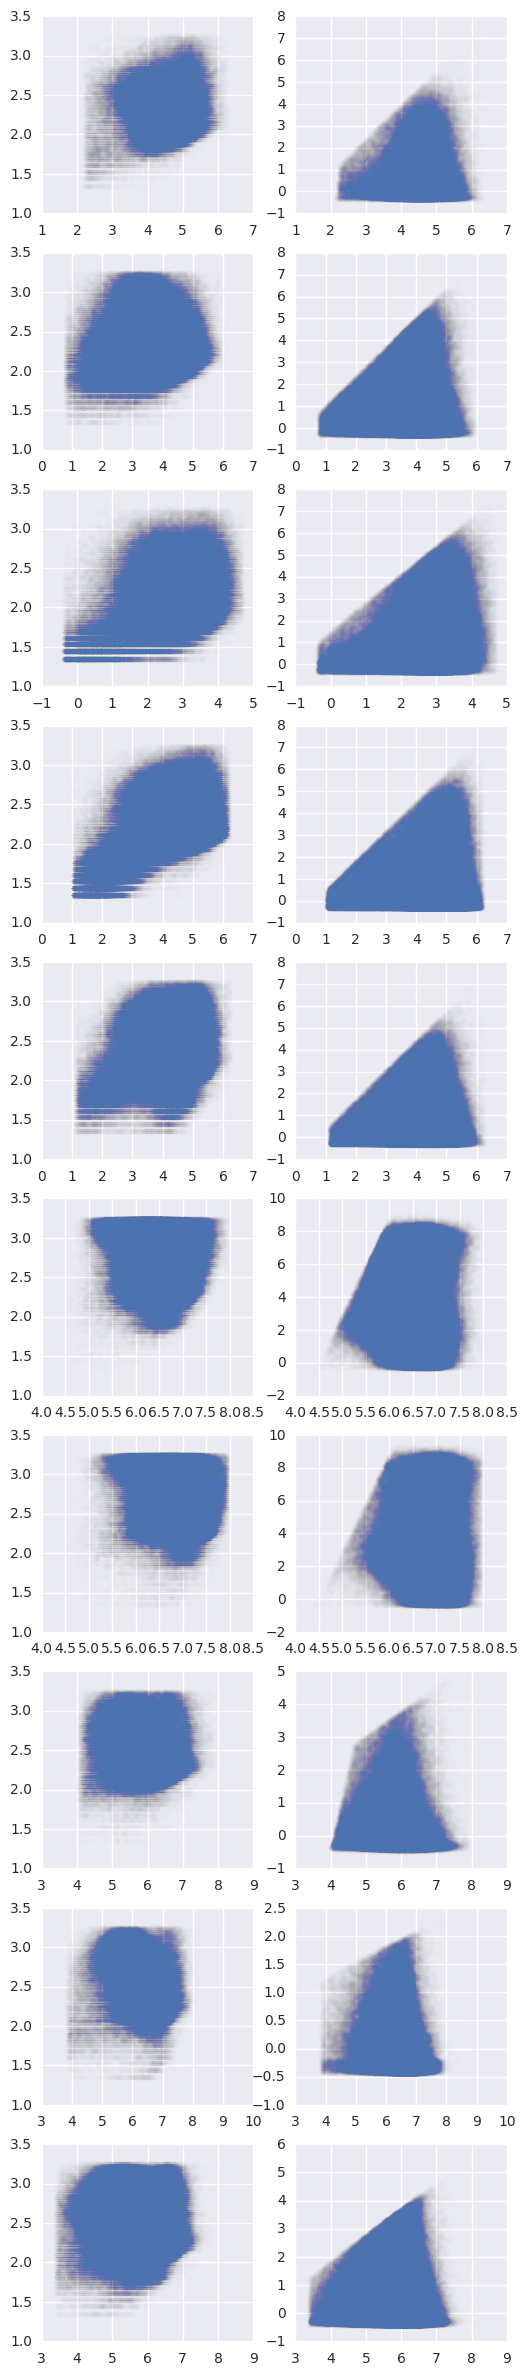

In [118]:
# preprocess data
f = lambda x: np.arcsinh((x -1.)/5.)
fig, axarr = plt.subplots(10, 2,figsize = (6,30))
for i in range(10):
    id = user_ids[i]
    axarr[i,0].scatter(data_dict[id]['DNA1'].apply(f),data_dict[id]['Cell_length'].apply(f),alpha = 0.002)
    axarr[i,1].scatter(data_dict[id]['DNA1'].apply(f),data_dict[id]['Viability'].apply(f),alpha = 0.002)
plt.show()

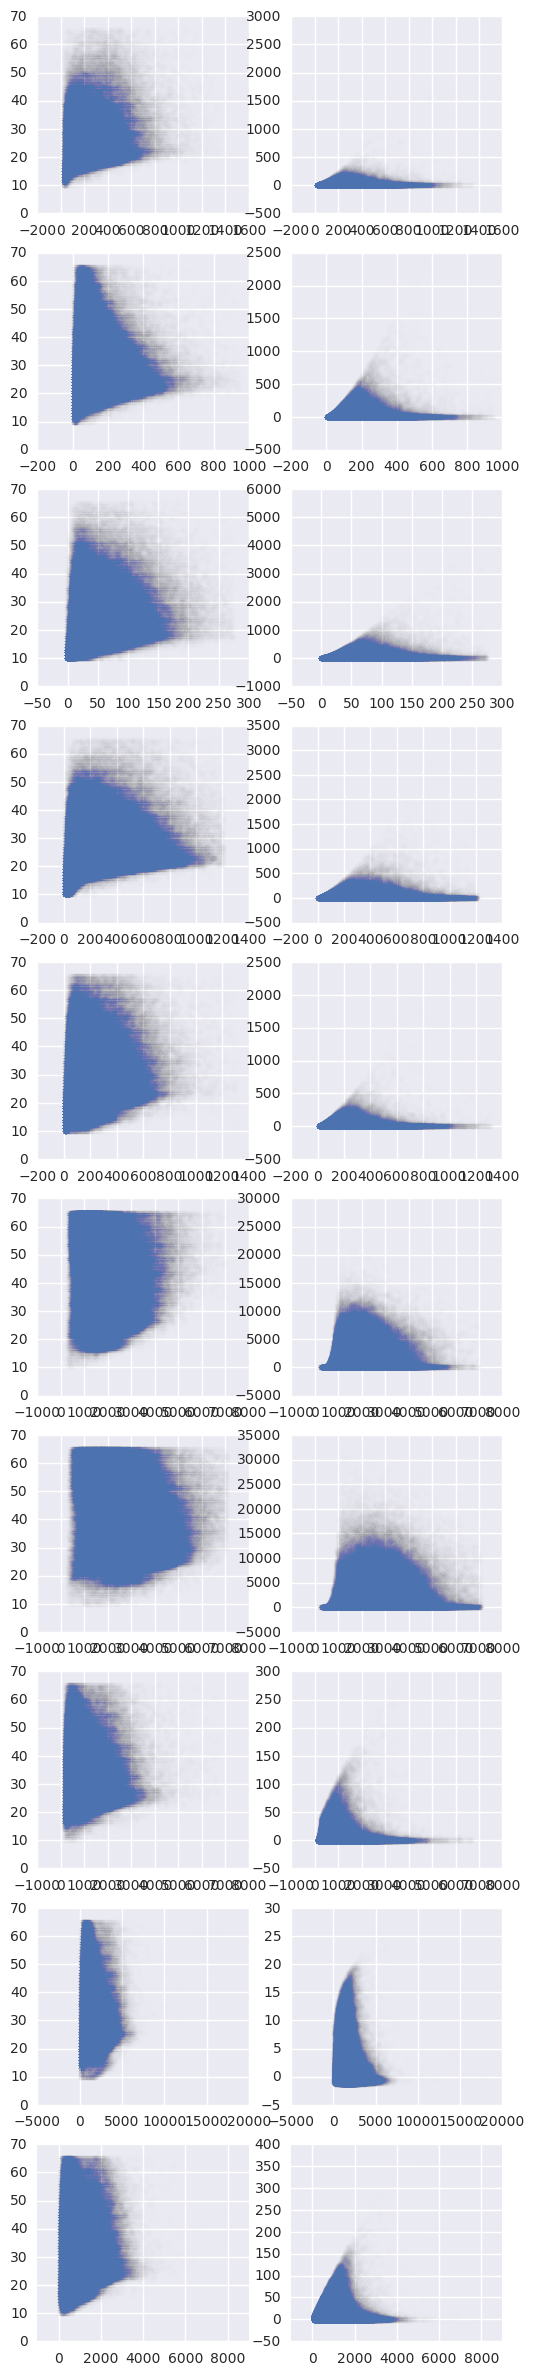

In [119]:
# preprocess data
fig, axarr = plt.subplots(10, 2,figsize = (6,30))
for i in range(10):
    id = user_ids[i]
    axarr[i,0].scatter(data_dict[id]['DNA1'],data_dict[id]['Cell_length'],alpha = 0.002)
    axarr[i,1].scatter(data_dict[id]['DNA1'],data_dict[id]['Viability'],alpha = 0.002)
plt.show()

In [1]:
a = [[0.11695, 0.2702, 0.05845, 0.04845, 0.03055, 0.03085, 0.01, 0.02045, 0.2049, 0.00245, 0.02375, 0.0148, 0.1195, 0.0487], [0.07935, 0.261, 0.0192, 0.04775, 0.02305, 0.0397, 0.01335, 0.01265, 0.1782, 0.00285, 0.0207, 0.0088, 0.251, 0.0424], [0.07145, 0.19265, 0.04445, 0.04995, 0.02705, 0.0839, 0.0294, 0.01005, 0.17825, 0.00185, 0.01565, 0.02, 0.215, 0.06035], [0.0629, 0.30135, 0.07255, 0.03075, 0.0178, 0.04685, 0.02975, 0.0292, 0.13165, 0.0047, 0.0038, 0.00515, 0.1956, 0.06795], [0.06285, 0.32115, 0.07475, 0.05365, 0.0258, 0.04045, 0.02625, 0.04255, 0.17905, 0.0032, 0.0065, 0.00715, 0.0788, 0.07785], [0.02285, 0.094, 0.00385, 0.06645, 0.03355, 0.1394, 0.04295, 0.08825, 0.17035, 0.01535, 0.0219, 0.11965, 0.16235, 0.0191], [0.0562, 0.12005, 0.0214, 0.0217, 0.01245, 0.1031, 0.06815, 0.07225, 0.26855, 0.00295, 0.0165, 0.07925, 0.07675, 0.0807], [0.06745, 0.06225, 0.00665, 0.02475, 0.014, 0.1142, 0.1241, 0.0891, 0.1214, 0.0009, 0.0079, 0.165, 0.13595, 0.06635], [0.04785, 0.0982, 0.0183, 0.0337, 0.0252, 0.1627, 0.14, 0.07105, 0.0965, 0.0042, 0.00055, 0.07485, 0.1253, 0.1016], [0.1004, 0.13045, 0.02705, 0.0355, 0.02115, 0.0436, 0.0305, 0.0389, 0.28675, 0.0021, 0.01025, 0.03245, 0.1119, 0.129], [0.0901, 0.1328, 0.0345, 0.06835, 0.03685, 0.04555, 0.03725, 0.0128, 0.2472, 0.01905, 0.0103, 0.02525, 0.1413, 0.0987], [0.0597, 0.0885, 0.0141, 0.06695, 0.03355, 0.0796, 0.1, 0.0808, 0.22355, 0.00315, 0.0129, 0.0697, 0.06885, 0.09865], [0.1588, 0.10765, 0.0118, 0.0753, 0.07155, 0.05425, 0.03435, 0.13175, 0.17995, 0.0175, 0.00895, 0.0, 0.034, 0.11415], [0.0937, 0.10355, 0.00805, 0.0534, 0.0295, 0.064, 0.0048, 0.0475, 0.50825, 0.0384, 0.01965, 0.0049, 0.01395, 0.01035], [0.1049, 0.17905, 0.042, 0.03085, 0.0232, 0.17175, 0.0, 0.05025, 0.12095, 0.0371, 0.00985, 0.0631, 0.07835, 0.08865], [0.12825, 0.0571, 0.0033, 0.06825, 0.0369, 0.00865, 0.07915, 0.00065, 0.50865, 0.03, 0.01685, 0.0, 0.00075, 0.0615], [0.0991, 0.1222, 0.03445, 0.0897, 0.0541, 0.14555, 0.14405, 0.05435, 0.09425, 0.0071, 0.0079, 0.0389, 0.0681, 0.04025], [0.076, 0.23785, 0.0523, 0.0536, 0.0344, 0.15835, 0.055, 0.08845, 0.1302, 0.01615, 0.01195, 0.06515, 0.014, 0.0066], [0.08665, 0.04205, 0.00365, 0.0256, 0.01715, 0.0962, 0.09345, 0.05245, 0.1955, 0.0027, 0.02, 0.12245, 0.1548, 0.08735], [0.00835, 0.059, 0.0178, 0.11895, 0.0745, 0.15145, 0.0688, 0.04765, 0.139, 0.01315, 0.0134, 0.1127, 0.1662, 0.00905], [0.07465, 0.179, 0.03725, 0.0915, 0.0622, 0.0726, 0.06955, 0.01775, 0.1666, 0.02095, 0.0166, 0.13345, 0.02985, 0.02805]]

In [3]:
import numpy as np
population_size = np.array(a)
print population_size[:,5:7]

[[ 0.03085  0.01   ]
 [ 0.0397   0.01335]
 [ 0.0839   0.0294 ]
 [ 0.04685  0.02975]
 [ 0.04045  0.02625]
 [ 0.1394   0.04295]
 [ 0.1031   0.06815]
 [ 0.1142   0.1241 ]
 [ 0.1627   0.14   ]
 [ 0.0436   0.0305 ]
 [ 0.04555  0.03725]
 [ 0.0796   0.1    ]
 [ 0.05425  0.03435]
 [ 0.064    0.0048 ]
 [ 0.17175  0.     ]
 [ 0.00865  0.07915]
 [ 0.14555  0.14405]
 [ 0.15835  0.055  ]
 [ 0.0962   0.09345]
 [ 0.15145  0.0688 ]
 [ 0.0726   0.06955]]


In [4]:
df.columns

Index([u'CD45RA', u'CD133', u'CD19', u'CD22', u'CD11b', u'CD4', u'CD8',
       u'CD34', u'Flt3', u'CD20', u'CXCR4', u'CD235ab', u'CD45', u'CD123',
       u'CD321', u'CD14', u'CD33', u'CD47', u'CD11c', u'CD7', u'CD15', u'CD16',
       u'CD44', u'CD38', u'CD13', u'CD3', u'CD61', u'CD117', u'CD49d',
       u'HLA-DR', u'CD64', u'CD41', u'cell_type'],
      dtype='object')

In [10]:
import seaborn as sns
import random
f = lambda X: np.arcsinh((X-1.)/5.)
sub_df = df.ix[np.random.choice(df.index, 10000)].reset_index()[df.columns[0:-1]].applymap(f)

/home/disij/.local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/home/disij/.local/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [11]:
# load AML data and table
##### X: np.array, flow cytometry data, arcsin transformed
##### T: table of expert knowledge

np.random.seed(1234)
PATH = '/home/disij/projects/acdc/data/'

### LOAD DATA ###
path = PATH + 'AML_benchmark/'
df = pd.read_csv( path + 'AML_benchmark.csv.gz', sep=',', header = 0, compression = 'gzip', engine='python')
table = pd.read_csv(path + 'AML_table.csv', sep=',', header=0, index_col=0)
print table.shape

### PROCESS: discard ungated events ###
df = df[df.cell_type != 'NotGated']
df = df.drop(['Time', 'Cell_length','file_number', 'event_number', 'DNA1(Ir191)Di',
              'DNA2(Ir193)Di', 'Viability(Pt195)Di', 'subject'], axis = 1)
channels = [item[:item.find('(')] for item in df.columns[:-1]]
df.columns = channels + ['cell_type']
df = df.loc[df['cell_type'] != 'NotDebrisSinglets']
print df.shape

table = table.fillna(0)
X = df[channels].values
table_headers = list(table)
# df2 = pd.DataFrame([[0]*table.shape[1]], columns=table.columns, index =['unknown'])
# table = table.append(df2)

### transform data
data = np.arcsinh((X-1.)/5.)
theta_space = np.array([[data[:,d].min(), data[:,d].max()] for d in range(data.shape[1])])


cell_type_name2idx = {x:i for i,x in enumerate(table.index)}
Y = np.array([cell_type_name2idx[_] for _ in df.cell_type])

df['cell_type'].value_counts()

(14, 32)
(104184, 33)


CD4 T cells               26366
Monocytes                 21099
CD8 T cells               20108
Mature B cells            16520
Pre B cells                6135
CD16- NK cells             3905
CD34+CD38+CD123- HSPCs     3295
CD16+ NK cells             2248
pDCs                       1238
Basophils                  1207
CD34+CD38lo HSCs            916
Pro B cells                 513
Plasma B cells              330
CD34+CD38+CD123+ HSPCs      304
Name: cell_type, dtype: int64

In [12]:
vmin=df[channels].applymap(f).values.min()
vmax=df[channels].applymap(f).values.max()
print vmin, vmax

-0.2554883189308806 7.2754298235190715


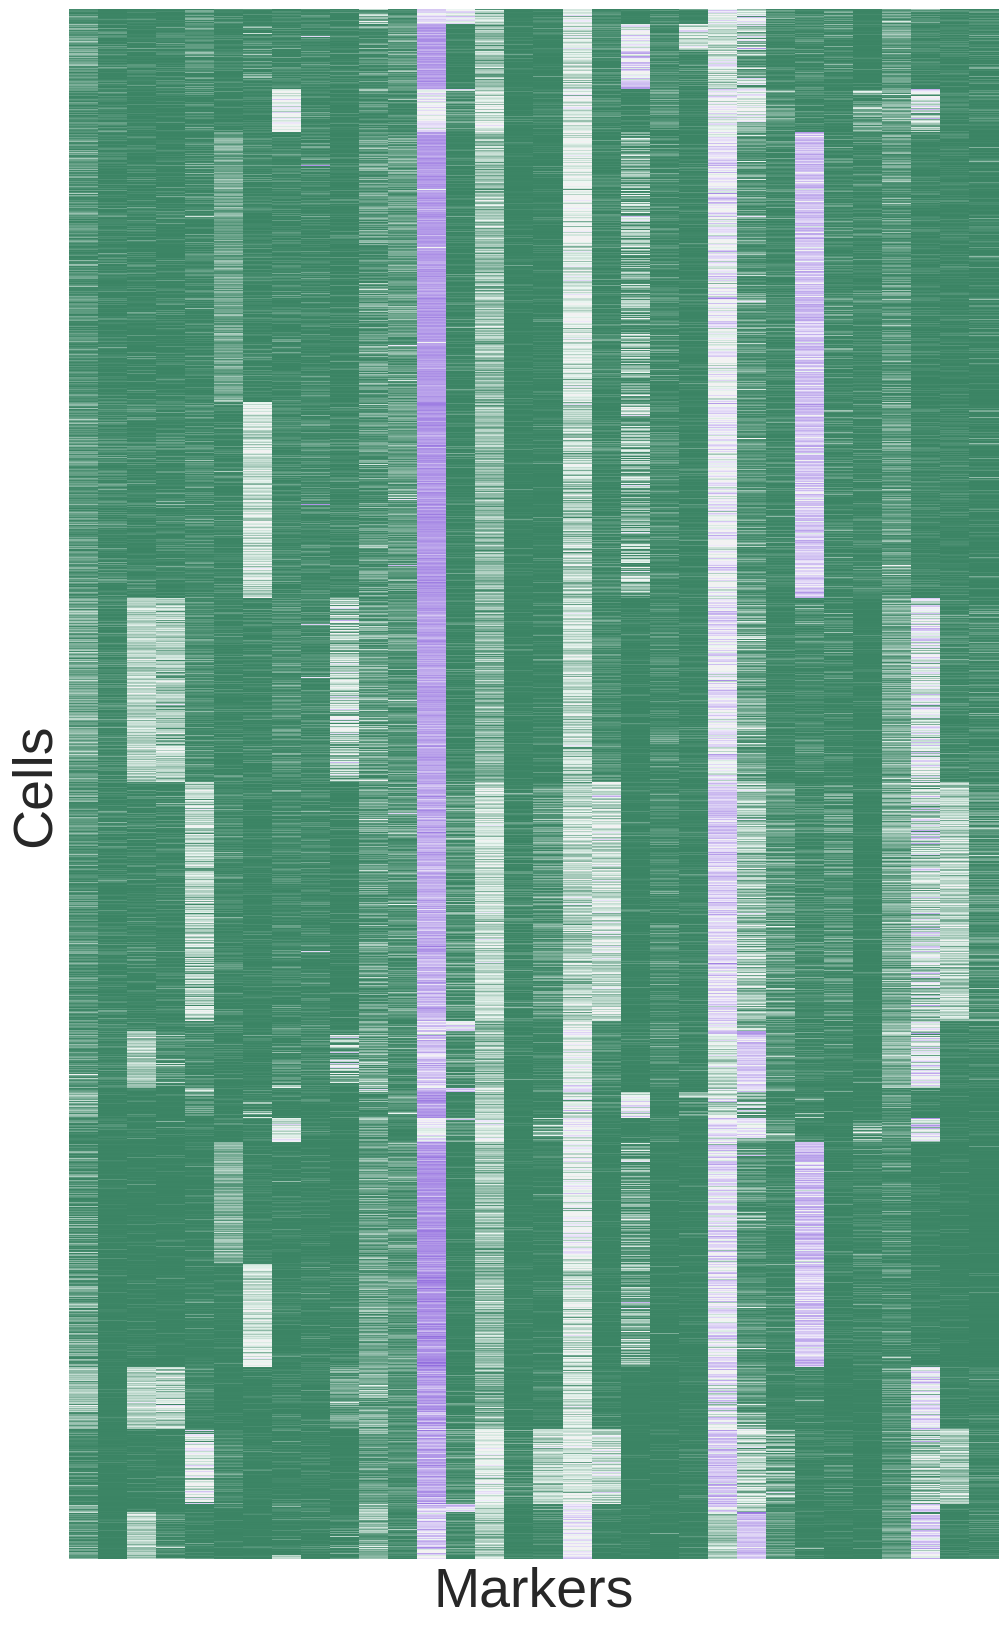

In [38]:
# plot heatmap
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
fig, ax = plt.subplots()
vmin=df[channels].applymap(f).values.min()
vmax=df[channels].applymap(f).values.max()
normalize = lambda x: (x-vmin)/(vmax-vmin)
cmap = sns.diverging_palette(150, 275, sep=20, as_cmap=True)
ax = sns.heatmap(df[channels].applymap(f).applymap(normalize),xticklabels=False,yticklabels=False,cmap=cmap,\
                 cbar = False,ax = ax)
ax.set_xlabel("Markers",fontsize=40)
ax.set_ylabel("Cells",fontsize=40)

fig.set_size_inches(12, 20)
plt.savefig('data_heatmap.png')
plt.show()

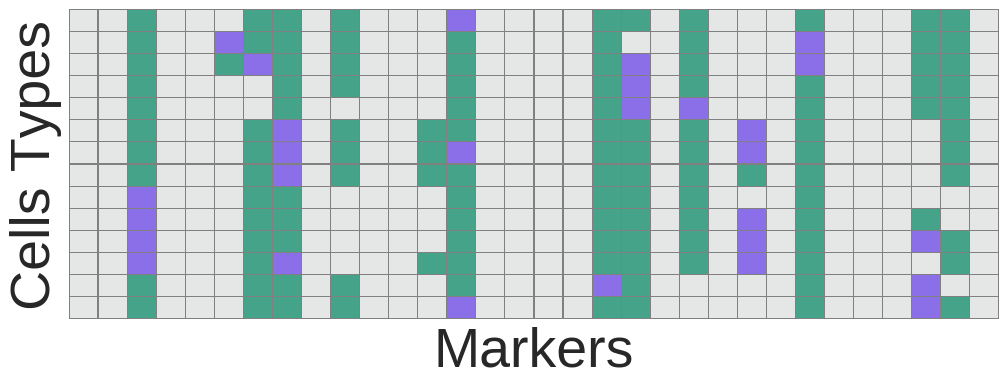

In [41]:
# plot heatmap
sns.set(font_scale=4)
fig, ax = plt.subplots()
# cmap = [[ 0.26613466,  0.47369811,  0.7317616 ,  1.        ], \
#         [ 0.9,  0.9 ,  0.9,  1.        ], \
#         [ 0.85453713,  0.22957019,  0.27623218,  1.        ]]
cmap = [[ 68./255, 163./255, 136./255 ,  1.        ], \
        [ 0.9,  0.9 ,  0.9,  1.        ], \
        [ 139./255, 111./255, 232./255,  1.        ]]
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('Custom', cmap, len(cmap))
sns.heatmap(table.values.astype(int), annot=True, fmt='f', cmap=cmap, \
            linewidths=.1, linecolor='gray',\
            xticklabels=False,yticklabels=False,ax = ax ,cbar = False )

# Manually specify colorbar labelling after it's been generated
# colorbar = ax.collections[0].colorbar
# colorbar.set_ticks([-0.667, 0, 0.667])
# colorbar.set_ticklabels(['-1: Low','0: Irrelevant','+1: High'])

ax.set_xlabel("Markers",fontsize=40)
ax.set_ylabel("Cells Types",fontsize=40)

# Only y-axis labels need their rotation set, x-axis labels already have a rotation of 0
_, labels = plt.yticks()
plt.setp(labels, rotation=0)
fig.set_size_inches(12, 4)
plt.savefig('table_heatmap.png')
plt.show()



# sns.heatmap(table,xticklabels=True,yticklabels=False,cmap = "Blues",\
#             cbar=True,annot=True, fmt="d",vmin=-1.0, vmax=1.0,ax = ax)


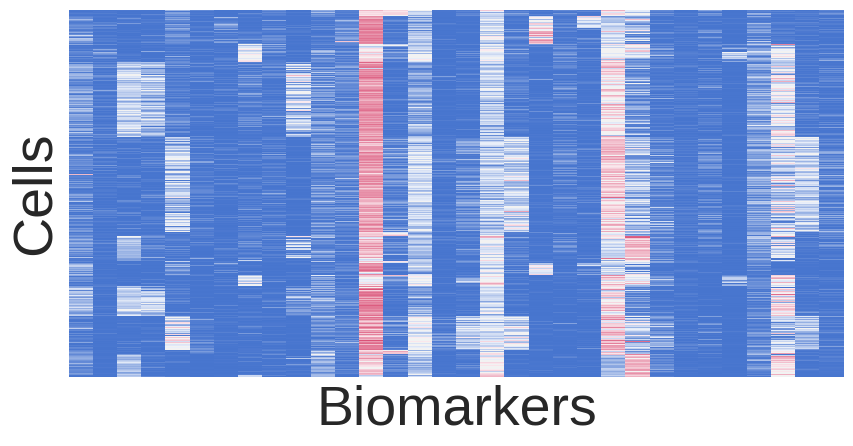

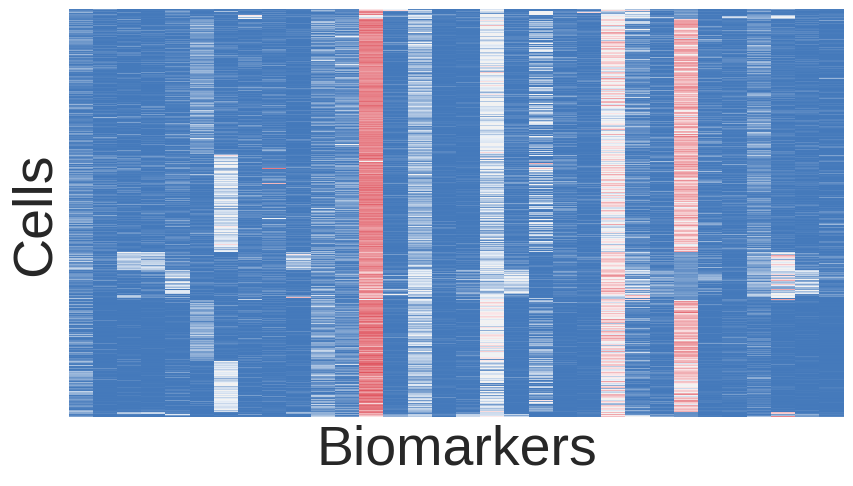

In [42]:
# plot heatmap

val = 2.7

import matplotlib.colors as colors
fig, ax = plt.subplots()
vmin=df[channels].applymap(f).values.min()
vmax=df[channels].applymap(f).values.max()
normalize = lambda x: (x-vmin)/(vmax-vmin)
cmap = sns.diverging_palette(250, 10, sep=20, as_cmap=True)
ax = sns.heatmap(df[df['CD3'] < val][channels].applymap(f).applymap(normalize),xticklabels=False,yticklabels=False,cmap=cmap,\
                 cbar = False,ax = ax)
ax.set_xlabel("Biomarkers",fontsize=40)
ax.set_ylabel("Cells",fontsize=40)

fig.set_size_inches(10, 10. / df.shape[0] * df[df['CD3'] < val].shape[0])

plt.show()


# plot heatmap
import matplotlib.colors as colors
fig, ax = plt.subplots()
vmin=df[channels].applymap(f).values.min()
vmax=df[channels].applymap(f).values.max()
normalize = lambda x: (x-vmin)/(vmax-vmin)
cmap = sns.diverging_palette(250, 10, sep=20, as_cmap=True)
ax = sns.heatmap(df[df['CD3'] > val][channels].applymap(f).applymap(normalize),xticklabels=False,yticklabels=False,cmap=cmap,\
                 cbar = False,ax = ax)
ax.set_xlabel("Biomarkers",fontsize=40)
ax.set_ylabel("Cells",fontsize=40)

fig.set_size_inches(10, 10. / df.shape[0] * df[df['CD3'] > val].shape[0])

plt.show()

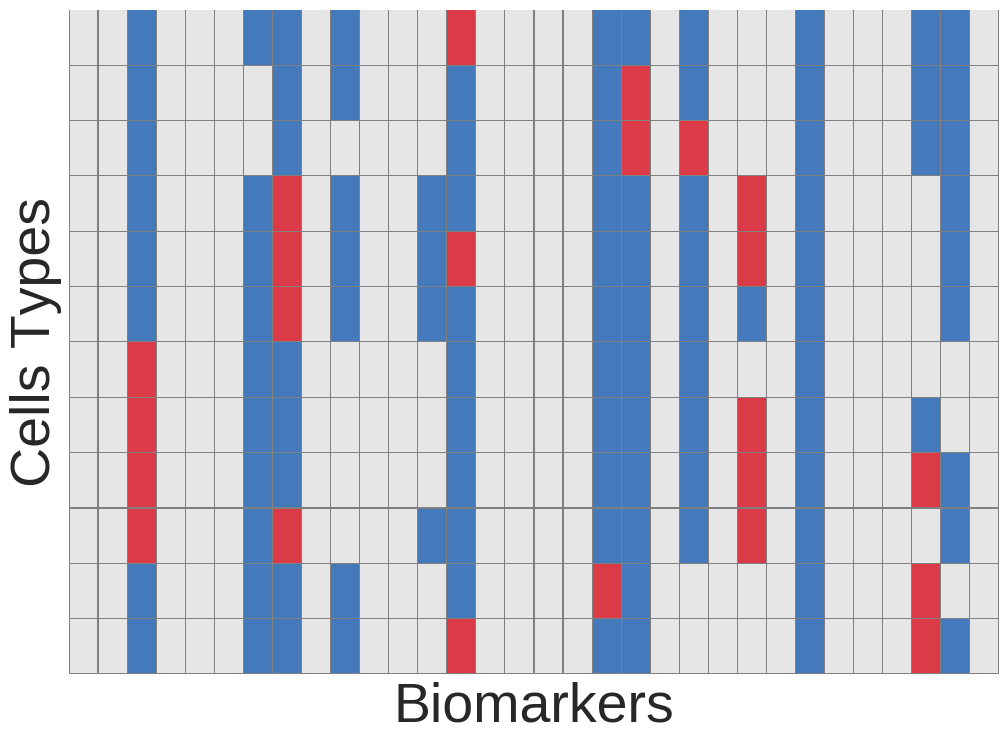

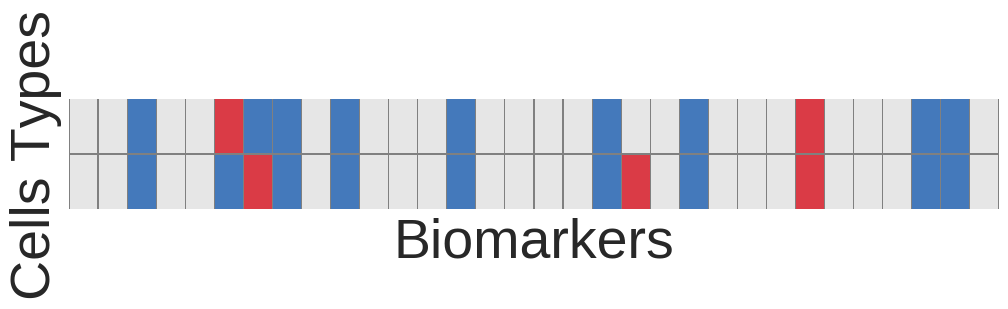

In [106]:
# plot heatmap
sns.set(font_scale=4)
fig, ax = plt.subplots()
cmap = [[ 0.26613466,  0.47369811,  0.7317616 ,  1.        ], \
        [ 0.9,  0.9 ,  0.9,  1.        ], \
        [ 0.85453713,  0.22957019,  0.27623218,  1.        ]]
cmap = LinearSegmentedColormap.from_list('Custom', cmap, len(cmap))
sns.heatmap(table[table['CD3'] < 0].values.astype(int), annot=True, fmt='f', cmap=cmap, \
            linewidths=.1, linecolor='gray',\
            xticklabels=False,yticklabels=False,ax = ax,cbar = False )

ax.set_xlabel("Biomarkers",fontsize=40)
ax.set_ylabel("Cells Types",fontsize=40)

# Only y-axis labels need their rotation set, x-axis labels already have a rotation of 0
_, labels = plt.yticks()
plt.setp(labels, rotation=0)
fig.set_size_inches(12, 10. / table.shape[0] * table[table['CD3'] < 0].shape[0])
plt.show()



# sns.heatmap(table,xticklabels=True,yticklabels=False,cmap = "Blues",\
#             cbar=True,annot=True, fmt="d",vmin=-1.0, vmax=1.0,ax = ax)



# plot heatmap
sns.set(font_scale=4)
fig, ax = plt.subplots()
cmap = [[ 0.26613466,  0.47369811,  0.7317616 ,  1.        ], \
        [ 0.9,  0.9 ,  0.9,  1.        ], \
        [ 0.85453713,  0.22957019,  0.27623218,  1.        ]]
cmap = LinearSegmentedColormap.from_list('Custom', cmap, len(cmap))
sns.heatmap(table[table['CD3'] > 0].values.astype(int), annot=True, fmt='f', cmap=cmap, \
            linewidths=.1, linecolor='gray',\
            xticklabels=False,yticklabels=False,ax = ax,cbar = False )

ax.set_xlabel("Biomarkers",fontsize=40)
ax.set_ylabel("Cells Types",fontsize=40)

# Only y-axis labels need their rotation set, x-axis labels already have a rotation of 0
_, labels = plt.yticks()
plt.setp(labels, rotation=0)
fig.set_size_inches(12, 10. / table.shape[0] * table[table['CD3'] > 0].shape[0])
plt.show()



# sns.heatmap(table,xticklabels=True,yticklabels=False,cmap = "Blues",\
#             cbar=True,annot=True, fmt="d",vmin=-1.0, vmax=1.0,ax = ax)


In [107]:
print table['CD3']

Basophils                -1
CD4 T cells               1
CD8 T cells               1
CD16- NK cells           -1
CD16+ NK cells           -1
CD34+CD38+CD123- HSPCs   -1
CD34+CD38+CD123+ HSPCs   -1
CD34+CD38lo HSCs         -1
Mature B cells           -1
Plasma B cells           -1
Pre B cells              -1
Pro B cells              -1
Monocytes                -1
pDCs                     -1
Name: CD3, dtype: int64


# number of prefered tree structures.

In [10]:
print table

                        CD45RA  CD133  CD19  CD22  CD11b  CD4  CD8  CD34  \
Basophils                  0.0    0.0    -1   0.0    0.0  0.0 -1.0    -1   
CD4 T cells                0.0    0.0    -1   0.0    0.0  1.0 -1.0    -1   
CD8 T cells                0.0    0.0    -1   0.0    0.0 -1.0  1.0    -1   
CD16- NK cells             0.0    0.0    -1   0.0    0.0  0.0  0.0    -1   
CD16+ NK cells             0.0    0.0    -1   0.0    0.0  0.0  0.0    -1   
CD34+CD38+CD123- HSPCs     0.0    0.0    -1   0.0    0.0  0.0 -1.0     1   
CD34+CD38+CD123+ HSPCs     0.0    0.0    -1   0.0    0.0  0.0 -1.0     1   
CD34+CD38lo HSCs           0.0    0.0    -1   0.0    0.0  0.0 -1.0     1   
Mature B cells             0.0    0.0     1   0.0    0.0  0.0 -1.0    -1   
Plasma B cells             0.0    0.0     1   0.0    0.0  0.0 -1.0    -1   
Pre B cells                0.0    0.0     1   0.0    0.0  0.0 -1.0    -1   
Pro B cells                0.0    0.0     1   0.0    0.0  0.0 -1.0     1   
Monocytes   

In [13]:
def count_prefered_structures(table, cut_history):
    
    
    if sum(cut_history) == 0 or table.shape[0] == 1:
        return 1
    
    types_str = [' '.join([str(int(x)) for x in sorted(set(table[table.columns[d]]))]) 
                 for d in range(table.shape[1])]
    
    if set([types_str[d] for d in range(table.shape[1]) if cut_history[d] == 1]).issubset({'0','1','-1'}):
        return 1
    
    res = 0
    
    if '-1 1' in types_str:
        for d in range(table.shape[1]):
            if types_str[d] == "-1 1":
                idx_table_left = table[table.columns[d]] != 1
                table_left = table.loc[idx_table_left]

                idx_table_right = table[table.columns[d]] != -1
                table_right = table.loc[idx_table_right]
                
                new_cut_history = np.copy(cut_history)
                new_cut_history[d] = 0
                res += count_prefered_structures(table_left, new_cut_history) + \
                        count_prefered_structures(table_right, new_cut_history)
        return res
    
    if "-1 0 1" in types_str:
        for d in range(table.shape[1]):
            if types_str[d] == "-1 0 1":
                idx_table_left = table[table.columns[d]] != 1
                table_left = table.loc[idx_table_left]

                idx_table_right = table[table.columns[d]] != -1
                table_right = table.loc[idx_table_right]
                
                new_cut_history = np.copy(cut_history)
                new_cut_history[d] = 0
                res += count_prefered_structures(table_left, new_cut_history) + \
                        count_prefered_structures(table_right, new_cut_history)
        return res
    
    if "-1 0" in types_str or "0 1" in types_str:
        for d in range(table.shape[1]):
            if types_str[d] == "-1 0":
                idx_table_left = table[table.columns[d]] == -1
                table_left = table.loc[idx_table_left]

                idx_table_right = table[table.columns[d]] == 0
                table_right = table.loc[idx_table_right]    
                
                new_cut_history = np.copy(cut_history)
                new_cut_history[d] = 0
                res += count_prefered_structures(table_left, new_cut_history) + \
                        count_prefered_structures(table_right, new_cut_history)
                    
            if types_str[d] == "0 1":
                idx_table_left = table[table.columns[d]] == 0
                table_left = table.loc[idx_table_left]

                idx_table_right = table[table.columns[d]] == 1
                table_right = table.loc[idx_table_right]
                new_cut_history = np.copy(cut_history)
                new_cut_history[d] = 0
                res += count_prefered_structures(table_left, new_cut_history) + \
                        count_prefered_structures(table_right, new_cut_history)
        return res

    
    
    return 1

In [17]:
np.random.seed(1234)
PATH = '/home/disij/projects/acdc/data/'

### LOAD DATA ###
path = PATH + 'AML_benchmark/'
df = pd.read_csv( path + 'AML_benchmark.csv.gz', sep=',', header = 0, compression = 'gzip', engine='python')
table = pd.read_csv(path + 'AML_table.csv', sep=',', header=0, index_col=0)
print table.shape

### PROCESS: discard ungated events ###
df = df[df.cell_type != 'NotGated']
df = df.drop(['Time', 'Cell_length','file_number', 'event_number', 'DNA1(Ir191)Di',
              'DNA2(Ir193)Di', 'Viability(Pt195)Di', 'subject'], axis = 1)
channels = [item[:item.find('(')] for item in df.columns[:-1]]
df.columns = channels + ['cell_type']
df = df.loc[df['cell_type'] != 'NotDebrisSinglets']
print df.shape

table = table.fillna(0)
X = df[channels].values
table_headers = list(table)
# df2 = pd.DataFrame([[0]*table.shape[1]], columns=table.columns, index =['unknown'])
# table = table.append(df2)

print count_prefered_structures(table, [1 for d in range(table.shape[1])])

(14, 32)
(104184, 33)
6732


In [18]:
# load BMMC data and table
##### X: np.array, flow cytometry data, arcsin transformed
##### T: table of expert knowledge

np.random.seed(1234)
PATH = '/home/disij/projects/acdc/data/'

### LOAD DATA ###
path = PATH + 'BMMC_benchmark/'
df = pd.read_csv( path + 'BMMC_benchmark.csv.gz', sep=',', header = 0, compression = 'gzip', engine='python')
table = pd.read_csv(path + 'BMMC_table.csv', sep=',', header=0, index_col=0)
print table.shape

### PROCESS: discard ungated events ###
channels = ['CD45','CD45RA', 'CD19', 'CD11b', 'CD4', 'CD8', 'CD34',
           'CD20', 'CD33', 'CD123', 'CD38', 'CD90', 'CD3']
df.columns = channels + ['cell_type']
df = df[df.cell_type != 'NotGated']
df = df.loc[df['cell_type'] != 'NotDebrisSinglets']
df = df.loc[df['cell_type'] != 'Megakaryocyte']
df = df.loc[df['cell_type'] != 'CD11bmid Monocyte']
df = df.loc[df['cell_type'] != 'Platelet']
df = df.loc[df['cell_type'] != 'Myelocyte']
df = df.loc[df['cell_type'] != 'Erythroblast']

table = table.fillna(0)
X = df[channels].values

print count_prefered_structures(table, [1 for d in range(table.shape[1])])

(19, 13)
6119
